In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
data_path = '/content/drive/MyDrive/Class1'

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os
import glob
import imageio.v3 as iio
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os

from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from keras.applications import ResNet50, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from keras.models import Model

In [ ]:
def load_file(file_path, label):
    file_path =file_path

    folder_name = file_path.split("/")[-1]

    out_list = []

    # Load every file .png format
    for image_path in glob.glob(file_path + "/*.PNG"):
        # Read image file
        image = iio.imread(image_path)

        # Declare temporary dict dtype
        temp = {}

        # Set the file name
        temp["name"] = image_path.split("/")[-1]

        # Set the file label, 0 for non defect. 1 for defect
        temp["label"] = label
        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:
            temp["data"] = image[:,:,0].astype("int")
        except:
            # Normal case
            temp["data"] = image.astype("int")

        # Append temp into output list
        out_list.append(temp)

    # Print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is   failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))

    # Convert list into numpy array dtype
    return np.array(out_list)

In [ ]:
defect_images_path = data_path + '/defect'
non_defect_images_path = data_path + '/non-defect'

defect_images = load_file(defect_images_path, 1)
non_defect_images = load_file(non_defect_images_path, 0)

loading file from folder: defect is successful
loading file from folder: non-defect is successful


In [ ]:
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from keras.applications import ResNet50, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from keras.models import Model

# Function to load images from a directory and label them
def load_file(image_dir, label, image_size=(512, 512)):
    images = []
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"The directory {image_dir} does not exist.")

    for filename in os.listdir(image_dir):
        # Load the image in grayscale mode
        img = load_img(os.path.join(image_dir, filename), color_mode='grayscale', target_size=image_size)
        img_array = img_to_array(img)
        images.append({'data': img_array, 'label': label})
    return np.array(images)

# Set the correct data path
data_path = data_path # Update this to the correct path
defect_images_path = os.path.join(data_path, 'defect')
non_defect_images_path = os.path.join(data_path, 'non-defect')

# Load defect and non-defect images
try:
    defect_images = load_file(defect_images_path, 1)
    non_defect_images = load_file(non_defect_images_path, 0)
except FileNotFoundError as e:
    print(e)
    # Exit or handle the error as needed
    exit()

# Shuffle the images
np.random.shuffle(defect_images)
np.random.shuffle(non_defect_images)

# Balance the classes
class_size = min(defect_images.shape[0], non_defect_images.shape[0])

# Combine the balanced datasets
dataset = np.concatenate((defect_images[:class_size], non_defect_images[:class_size]))

# Create an empty matrix X and vector y
X = np.empty([dataset.shape[0], 512, 512, 1]).astype(np.float32)
y = np.empty(dataset.shape[0]).astype(np.int32)

# Assign the data to X and y
for i in range(dataset.shape[0]):
    X[i] = dataset[i]['data']
    y[i] = dataset[i]['label']

# Convert X to a TensorFlow tensor
X = tf.convert_to_tensor(X)

# Convert grayscale images to RGB and resize to (224, 224)
X_rgb = tf.image.grayscale_to_rgb(X)
X_rgb = tf.image.resize(X_rgb, [224, 224])

# Convert back to numpy array for indexing
X_rgb = X_rgb.numpy()

# Display size of the labels
print(np.unique(y, return_counts=True))

(array([0, 1], dtype=int32), array([150, 150]))


In [ ]:
def create_smaller_hybrid_model(image_shape=(224, 224, 3), print_summary=False):
    input_tensor = Input(shape=image_shape)

    # Smaller ResNet (ResNet50 but truncated)
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in resnet_base.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False
    resnet_out = GlobalAveragePooling2D()(resnet_base.output)

    # Smaller DenseNet (DenseNet121 but truncated and renamed)
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in densenet_base.layers[:400]:  # Freeze first 400 layers
        layer._name = "dense_" + layer.name  # Rename each layer in DenseNet to avoid conflicts
        layer.trainable = False
    densenet_out = GlobalAveragePooling2D()(densenet_base.output)

    # Concatenate features
    combined_features = Concatenate()([resnet_out, densenet_out])

    # Dense layers for classification
    x = Dense(512, activation='relu')(combined_features)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Show the CNN model detail
    if print_summary:
        model.summary()

    return model

In [ ]:
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from keras.applications import ResNet50, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from keras.models import Model

kfold_splits = 4
n_epoch = 5
batch_size = 10
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(skf.split(X_rgb, y)):
    print(f'Training on fold {fold+1}/{kfold_splits}...')

    # Get the train and validation data for the current fold
    xtrain, xval = X_rgb[train_indices], X_rgb[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]

    # Print number of samples per class in the current fold
    print(f'ytrain: number of samples each class: {np.unique(ytrain, return_counts=True)}')
    print(f'yval: number of samples each class: {np.unique(yval, return_counts=True)}')

    # Create a new model instance
    model = create_smaller_hybrid_model(print_summary=(fold == 0))

    print(f'Training new iteration on {xtrain.shape[0]} training samples, {xval.shape[0]} validation samples, this may take a while...')

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'resnet_densenet_model_fold_{fold+1}.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(
        xtrain, ytrain,
        epochs=n_epoch,
        batch_size=batch_size,
        validation_data=(xval, yval),
        callbacks=[early_stopping, model_checkpoint]
    )

    print('— ' * 20)

Training on fold 1/4...
ytrain: number of samples each class: (array([0, 1], dtype=int32), array([113, 112]))
yval: number of samples each class: (array([0, 1], dtype=int32), array([37, 38]))
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 dense_input_4 (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 dense_zero_padding2d_2 (Ze  (None, 230, 230, 3)          0         ['dense_input_4[0][0]']       
 roPadding2D)                                                                                     
                                                                                                  
 dense_conv1/conv (Conv2D)   (None, 112, 112, 64)         9408      ['dense_zero_padding2d_2[0][0]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 43s 527ms/step - loss: 0.9762 - accuracy: 0.7911 - val_loss: 14.8673 - val_accuracy: 0.5067
Epoch 2/5
23/23 [==============================] - 1s 64ms/step - loss: 0.1746 - accuracy: 0.9467 - val_loss: 70.4679 - val_accuracy: 0.5067
Epoch 3/5
23/23 [==============================] - 3s 146ms/step - loss: 0.0466 - accuracy: 0.9778 - val_loss: 0.1665 - val_accuracy: 0.9467
Epoch 4/5
23/23 [==============================] - 1s 60ms/step - loss: 0.2017 - accuracy: 0.9556 - val_loss: 48.2407 - val_accuracy: 0.5067
Epoch 5/5
23/23 [==============================] - 3s 144ms/step - loss: 0.0568 - accuracy: 0.9911 - val_loss: 0.0785 - val_accuracy: 0.9867
— — — — — — — — — — — — — — — — — — — — 
Training on fold 2/4...
ytrain: number of samples each class: (array([0, 1], dtype=int32), array([113, 112]))
yval: number of samples each class: (array([0, 1], dtype=int32), array([37, 38]))
Training new iteration on 225 training samples, 75 validation samples,

Validation Accuracy Average: 0.664015
Validation Loss Average: 156.44247000000001


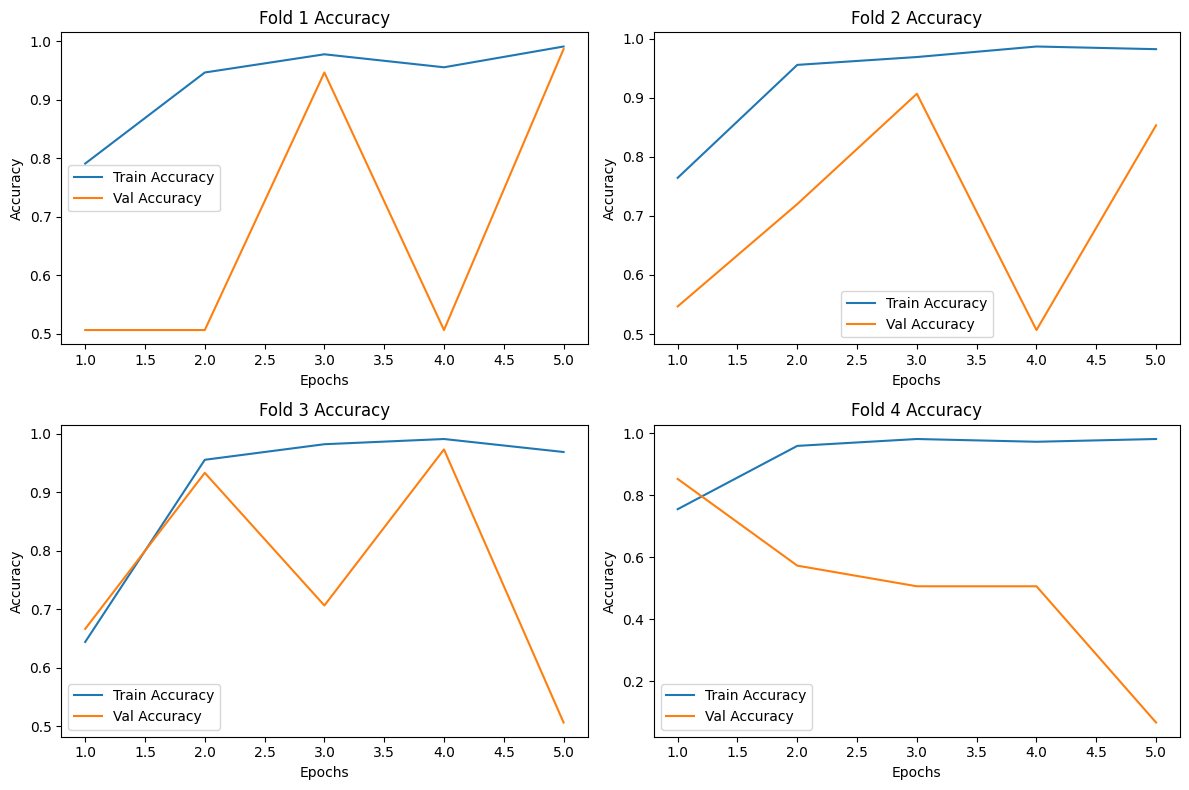

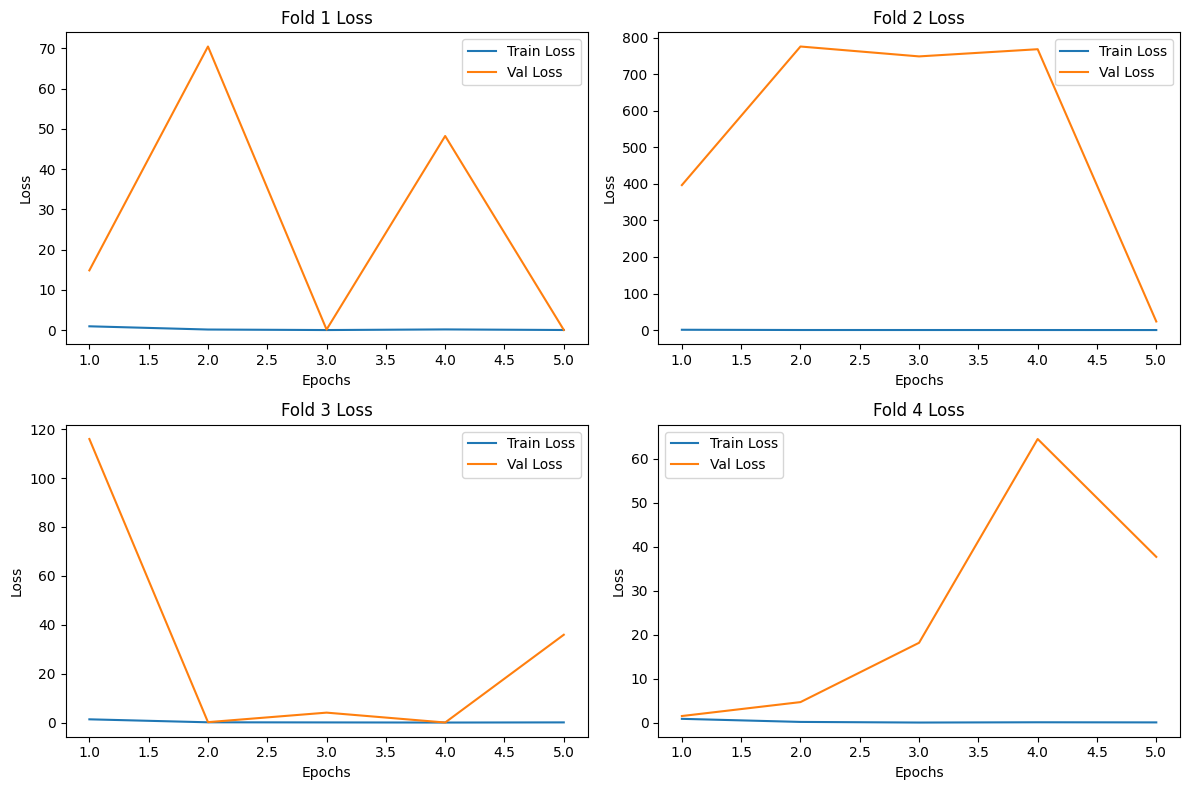

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Function to create epochs
def create_epoch(n=0):
    return np.arange(0, n) + 1

# Model evaluation results for each fold
fold1_epoch = create_epoch(n=5)
fold1_loss = np.array([0.9762, 0.1746, 0.0466, 0.2017, 0.0568])
fold1_acc = np.array([0.7911, 0.9467, 0.9778, 0.9556, 0.9911])
fold1_val_loss = np.array([14.8673, 70.4679, 0.1665, 48.2407, 0.0785])
fold1_val_acc = np.array([0.5067, 0.5067, 0.9467, 0.5067, 0.9867])

fold2_epoch = create_epoch(n=5)
fold2_loss = np.array([0.8193, 0.1544, 0.1246, 0.1010, 0.0485])
fold2_acc = np.array([0.7644, 0.9556, 0.9689, 0.9867, 0.9822])
fold2_val_loss = np.array([396.5156, 775.6182, 748.5649, 768.2001, 23.4625])
fold2_val_acc = np.array([0.5467, 0.7200, 0.9067, 0.5067, 0.8533])

fold3_epoch = create_epoch(n=5)
fold3_loss = np.array([1.3621, 0.1451, 0.0957, 0.0440, 0.1076])
fold3_acc = np.array([0.6444, 0.9556, 0.9822, 0.9911, 0.9689])
fold3_val_loss = np.array([115.9371, 0.2063, 4.0951, 0.0550, 35.9288])
fold3_val_acc = np.array([0.6667, 0.9333, 0.7067, 0.9733, 0.5067])

fold4_epoch = create_epoch(n=5)
fold4_loss = np.array([0.8723, 0.1718, 0.0299, 0.0904, 0.0634])
fold4_acc = np.array([0.7556, 0.9600, 0.9822, 0.9733, 0.9822])
fold4_val_loss = np.array([1.5114, 4.6747, 18.1517, 64.4395, 37.6676])
fold4_val_acc = np.array([0.8533, 0.5733, 0.5067, 0.5067, 0.0667])

# Calculate validation averages
val_acc_avg = (np.mean(fold1_val_acc) + np.mean(fold2_val_acc) + np.mean(fold3_val_acc) + np.mean(fold4_val_acc)) / 4
val_loss_avg = (np.mean(fold1_val_loss) + np.mean(fold2_val_loss) + np.mean(fold3_val_loss) + np.mean(fold4_val_loss)) / 4

print("Validation Accuracy Average:", val_acc_avg)
print("Validation Loss Average:", val_loss_avg)

# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))

# Fold 1
plt.subplot(2, 2, 1)
plt.plot(fold1_epoch, fold1_acc, label='Train Accuracy')
plt.plot(fold1_epoch, fold1_val_acc, label='Val Accuracy')
plt.title('Fold 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 2
plt.subplot(2, 2, 2)
plt.plot(fold2_epoch, fold2_acc, label='Train Accuracy')
plt.plot(fold2_epoch, fold2_val_acc, label='Val Accuracy')
plt.title('Fold 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 3
plt.subplot(2, 2, 3)
plt.plot(fold3_epoch, fold3_acc, label='Train Accuracy')
plt.plot(fold3_epoch, fold3_val_acc, label='Val Accuracy')
plt.title('Fold 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 4
plt.subplot(2, 2, 4)
plt.plot(fold4_epoch, fold4_acc, label='Train Accuracy')
plt.plot(fold4_epoch, fold4_val_acc, label='Val Accuracy')
plt.title('Fold 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation loss for each fold
plt.figure(figsize=(12, 8))

# Fold 1
plt.subplot(2, 2, 1)
plt.plot(fold1_epoch, fold1_loss, label='Train Loss')
plt.plot(fold1_epoch, fold1_val_loss, label='Val Loss')
plt.title('Fold 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 2
plt.subplot(2, 2, 2)
plt.plot(fold2_epoch, fold2_loss, label='Train Loss')
plt.plot(fold2_epoch, fold2_val_loss, label='Val Loss')
plt.title('Fold 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 3
plt.subplot(2, 2, 3)
plt.plot(fold3_epoch, fold3_loss, label='Train Loss')
plt.plot(fold3_epoch, fold3_val_loss, label='Val Loss')
plt.title('Fold 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 4
plt.subplot(2, 2, 4)
plt.plot(fold4_epoch, fold4_loss, label='Train Loss')
plt.plot(fold4_epoch, fold4_val_loss, label='Val Loss')
plt.title('Fold 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
